사전구성

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os

In [2]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  #CIFAR 32x32 -> 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409),  # CIFAR-100 평균
                         (0.2673, 0.2564, 0.2761))  # CIFAR-100 표준편차
])

In [3]:
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print("클래스 개수:", len(trainset.classes))    # 100
print("예시 클래스:", trainset.classes[:10])    # 앞 10개 클래스
print(trainset[0][0].shape)     #이미지 크기

클래스 개수: 100
예시 클래스: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']
torch.Size([3, 224, 224])


In [4]:
class myAlexNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1_1 = nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2)
        self.layer1_2 = nn.Conv2d(3, 48, kernel_size=11, stride=4, padding=2)
        self.lrn1  = nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.layer2_1 = nn.Conv2d(48, 128, kernel_size=5, padding=2)
        self.layer2_2 = nn.Conv2d(48, 128, kernel_size=5, padding=2)
        self.lrn2  = nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2.0)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.layer3_11 = nn.Conv2d(128, 192, kernel_size=3, padding=1, bias=False)
        self.layer3_12 = nn.Conv2d(128, 192, kernel_size=3, padding=1, bias=False)
        self.layer3_21 = nn.Conv2d(128, 192, kernel_size=3, padding=1)
        self.layer3_22 = nn.Conv2d(128, 192, kernel_size=3, padding=1)

        self.layer4_1 = nn.Conv2d(192, 192, kernel_size=3, padding=1)
        self.layer4_2 = nn.Conv2d(192, 192, kernel_size=3, padding=1)

        self.layer5_1 = nn.Conv2d(192, 128, kernel_size=3, padding=1)
        self.layer5_2 = nn.Conv2d(192, 128, kernel_size=3, padding=1)
        self.maxpool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.flatten = nn.Flatten()
        self.layer6_11 = nn.Linear(6*6*128, 2048, bias=False)
        self.layer6_12 = nn.Linear(6*6*128, 2048, bias=False)
        self.layer6_21 = nn.Linear(6*6*128, 2048)
        self.layer6_22 = nn.Linear(6*6*128, 2048)

        self.layer7_11 = nn.Linear(2048, 2048, bias=False)
        self.layer7_12 = nn.Linear(2048, 2048, bias=False)
        self.layer7_21 = nn.Linear(2048, 2048)
        self.layer7_22 = nn.Linear(2048, 2048)

        self.layer8_1 = nn.Linear(2048, 100, bias=False) #CIFAR은 100 class
        self.layer8_2 = nn.Linear(2048, 100)

    def forward(self, x):
        temp1 = self.layer1_1(x)
        temp2 = self.layer1_2(x)
        temp1, temp2 = self.maxpool1(self.lrn1(F.relu(temp1))), self.maxpool1(self.lrn1(F.relu(temp2)))

        temp1 = self.layer2_1(temp1)
        temp2 = self.layer2_2(temp2)
        temp1, temp2 = self.maxpool2(self.lrn2(F.relu(temp1))), self.maxpool2(self.lrn2(F.relu(temp2)))

        temp1, temp2 = self.layer3_11(temp1) + self.layer3_21(temp2), self.layer3_12(temp1) + self.layer3_22(temp2)
        
        temp1 = F.relu(self.layer4_1(temp1))
        temp2 = F.relu(self.layer4_2(temp2))

        temp1 = F.relu(self.layer5_1(temp1))
        temp2 = F.relu(self.layer5_2(temp2))
        temp1, temp2 = self.flatten(self.maxpool5(temp1)), self.flatten(self.maxpool5(temp2))

        temp1, temp2 = F.relu(self.layer6_11(temp1) + self.layer6_21(temp2)), F.relu(self.layer6_12(temp1) + self.layer6_22(temp2))

        temp1, temp2 = F.relu(self.layer7_11(temp1) + self.layer7_21(temp2)), F.relu(self.layer7_12(temp1) + self.layer7_22(temp2))

        x = self.layer8_1(temp1) + self.layer8_2(temp2)


        return x

In [5]:
@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss()
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        pred = logits.argmax(1)
        total += y.size(0)
        correct += (pred == y).sum().item()
        loss_sum += loss.item() * y.size(0)
    return loss_sum / total, correct / total

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = myAlexNet().to(device)

# Optim / Sched
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)  # 50 epochs 예시

# AMP(자동 혼합 정밀도) 권장
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

best_acc = 0.0
epochs = 50
os.makedirs('checkpoints', exist_ok=True)

for epoch in range(1, epochs+1):
    model.train()
    total, correct, run_loss = 0, 0, 0.0

    for x, y in trainloader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        run_loss += loss.item() * y.size(0)
        pred = logits.argmax(1)
        total += y.size(0)
        correct += (pred == y).sum().item()

    scheduler.step()
    train_loss = run_loss / total
    train_acc  = correct / total

    val_loss, val_acc = evaluate(model, testloader, device)

    print(f"[{epoch:02d}/{epochs}] "
            f"train_loss={train_loss:.4f} train_acc={train_acc*100:.2f}% | "
            f"val_loss={val_loss:.4f} val_acc={val_acc*100:.2f}% | "
            f"lr={scheduler.get_last_lr()[0]:.5f}")
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    # save best
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'val_acc': val_acc,
        }, f"checkpoints/best_alexnet_cifar100.pt")

print(f"Best val_acc: {best_acc*100:.2f}%")


C:\Users\xanle\AppData\Local\Temp\ipykernel_27284\3704915286.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))
C:\Users\xanle\AppData\Local\Temp\ipykernel_27284\3704915286.py:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


[01/50] train_loss=4.4200 train_acc=3.49% | val_loss=3.9919 val_acc=8.09% | lr=0.00999
[02/50] train_loss=3.6501 train_acc=14.06% | val_loss=3.3866 val_acc=19.17% | lr=0.00996
[03/50] train_loss=3.1081 train_acc=23.73% | val_loss=2.8826 val_acc=28.77% | lr=0.00991
[04/50] train_loss=2.6617 train_acc=32.73% | val_loss=2.5846 val_acc=35.31% | lr=0.00984
[05/50] train_loss=2.2485 train_acc=41.55% | val_loss=2.4409 val_acc=38.59% | lr=0.00976
[06/50] train_loss=1.8327 train_acc=50.81% | val_loss=2.3513 val_acc=41.68% | lr=0.00965
[07/50] train_loss=1.3441 train_acc=62.31% | val_loss=2.4289 val_acc=41.94% | lr=0.00952
[08/50] train_loss=0.8423 train_acc=75.11% | val_loss=2.6421 val_acc=42.47% | lr=0.00938
[09/50] train_loss=0.5075 train_acc=84.69% | val_loss=2.9908 val_acc=42.13% | lr=0.00922
[10/50] train_loss=0.3279 train_acc=90.23% | val_loss=3.4302 val_acc=42.61% | lr=0.00905
[11/50] train_loss=0.2192 train_acc=93.43% | val_loss=3.4204 val_acc=43.23% | lr=0.00885
[12/50] train_loss=0.13

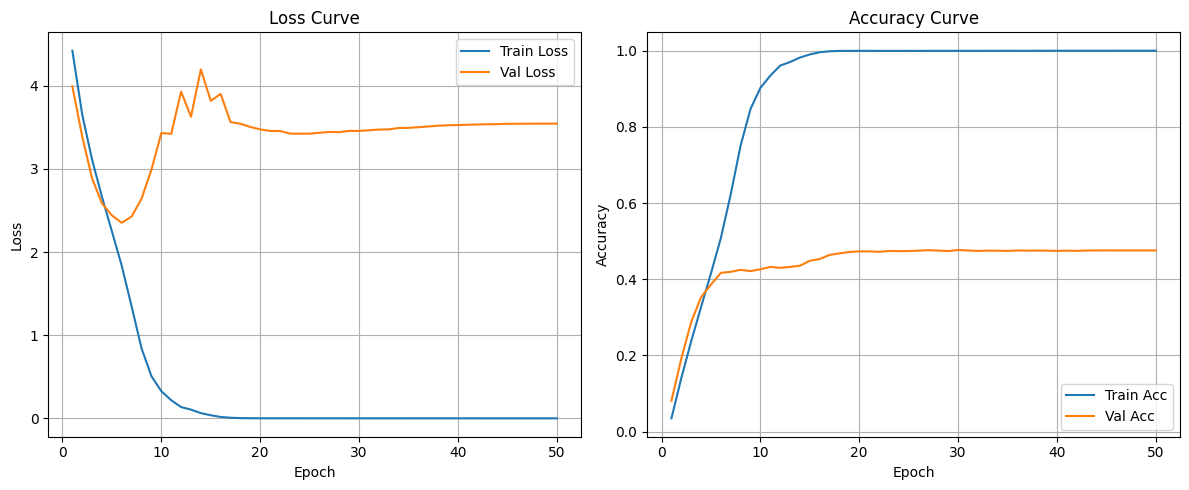

In [6]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs+1)

# Loss 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, label="Train Loss")
plt.plot(epochs_range, val_loss_history, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_history, label="Train Acc")
plt.plot(epochs_range, val_acc_history, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()